# Analisis Survival Breast Cancer MSK 2025

Notebook ini melakukan analisis survival pada data breast cancer dari MSK 2025, termasuk preprocessing data, pemodelan Cox Proportional Hazards, dan analisis Kaplan-Meier.

## Data Preparation

In [ ]:
import pandas as pd
# Import file .tsv
df = pd.read_csv('breast_msk_2025_clinical_data.tsv', sep='\t')

# Tampilkan nama kolom
print("Nama kolom:")
print(df.columns.tolist())

Nama kolom:
['Study ID', 'Patient ID', 'Sample ID', 'Cancer Type', 'Cancer Type Detailed', 'Ethnicity', 'Fraction Genome Altered', 'Sex', 'Gene Panel', 'Metastatic Site', 'MSI Comment', 'MSI Score', 'MSI Type', 'Mutation Count', 'Oncotree Code', 'Overall Survival (Months)', 'Overall Survival Status', 'Primary Tumor Site', 'Race', 'Sample Class', 'Number of Samples Per Patient', 'Sample coverage', 'Sample Type', 'Somatic Status', 'Tumor Purity']


## Data Loading

## Data Cleaning and Preprocessing

In [14]:
# Data Preprocessing

# Cek nilai unik di kolom 'Sex'
print("Nilai unik di kolom 'Sex' sebelum cleaning:")
print(df['Sex'].unique())

# Standardize nilai di kolom 'Sex' ke 'Male' dan 'Female'
df['Sex'] = df['Sex'].str.capitalize()  # Capitalize untuk membuat Female dan Male

# Pastikan hanya Male dan Female, drop atau handle lainnya jika ada
df = df[df['Sex'].isin(['Male', 'Female'])]

print("Nilai unik di kolom 'Sex' setelah cleaning:")
print(df['Sex'].unique())

# Cek nilai unik di kolom 'Overall Survival Status' sebelum mapping
print("Nilai unik di kolom 'Overall Survival Status' sebelum mapping:")
print(df['Overall Survival Status'].unique())

# Mengubah nilai di kolom 'Overall Survival Status' (pindah ke sini)
df['Overall Survival Status'] = df['Overall Survival Status'].map({'1:DECEASED': 1, '0:LIVING': 0})

# Tampilkan nilai unik setelah mapping untuk verifikasi
print("Nilai unik di kolom 'Overall Survival Status' setelah mapping:")
print(df['Overall Survival Status'].unique())

# Drop NaN di kolom yang diperlukan untuk analisis Cox dan KM
columns_needed = [
    'Overall Survival (Months)',
    'Overall Survival Status',
    'Sex',
    'Cancer Type Detailed',
    'Primary Tumor Site',
    'MSI Type',
    'Mutation Count',
    'Fraction Genome Altered'
]
df = df.dropna(subset=columns_needed)

print(f"Jumlah sampel setelah preprocessing: {len(df)}")

Nilai unik di kolom 'Sex' sebelum cleaning:
['FEMALE' 'Female' 'Male' 'Unknown' 'MALE']
Nilai unik di kolom 'Sex' setelah cleaning:
['Female' 'Male']
Nilai unik di kolom 'Overall Survival Status' sebelum mapping:
['1:DECEASED' '0:LIVING']
Nilai unik di kolom 'Overall Survival Status' setelah mapping:
[1 0]
Jumlah sampel setelah preprocessing: 3656


# Pemodelan Cox Regression

In [15]:
from lifelines import CoxPHFitter
import pandas as pd

# Pilih kolom yang diperlukan
columns_needed = [
    'Overall Survival (Months)',
    'Overall Survival Status',
    'Sex',
    'Cancer Type Detailed',
    'Primary Tumor Site',
    'MSI Type',
    'Mutation Count',
    'Fraction Genome Altered'
]

# Buat subset data (sudah drop NaN di preprocessing)
data_cox = df[columns_needed]

# Pastikan tipe data benar
data_cox['Overall Survival (Months)'] = data_cox['Overall Survival (Months)'].astype(float)
data_cox['Overall Survival Status'] = data_cox['Overall Survival Status'].astype(int)

# Encode kolom kategorikal ke dummy variables
categorical_cols = ['Cancer Type Detailed', 'Primary Tumor Site', 'MSI Type', 'Sex']
data_cox_encoded = pd.get_dummies(data_cox, columns=categorical_cols, drop_first=True)

# Tampilkan info data setelah encoding
print(f"Jumlah sampel setelah encoding: {len(data_cox_encoded)}")
print("Kolom setelah encoding:")
print(data_cox_encoded.columns.tolist())

# Fit model Cox Proportional Hazards
cph = CoxPHFitter(penalizer=0.1)  # Tambahkan penalizer untuk mengatasi kolinearitas
cph.fit(data_cox_encoded, duration_col='Overall Survival (Months)', event_col='Overall Survival Status')

# Tampilkan summary model
print("\nSummary Model Cox:")
print(cph.summary)

C:\Users\LENOVO\AppData\Local\Temp\ipykernel_1408\2579703918.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_cox['Overall Survival (Months)'] = data_cox['Overall Survival (Months)'].astype(float)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_1408\2579703918.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_cox['Overall Survival Status'] = data_cox['Overall Survival Status'].astype(int)


Jumlah sampel setelah encoding: 3656
Kolom setelah encoding:
['Overall Survival (Months)', 'Overall Survival Status', 'Mutation Count', 'Fraction Genome Altered', 'Cancer Type Detailed_Adenomyoepithelioma of the Breast', 'Cancer Type Detailed_Breast Ductal Carcinoma In Situ', 'Cancer Type Detailed_Breast Invasive Cancer, NOS', 'Cancer Type Detailed_Breast Invasive Carcinoma, NOS', 'Cancer Type Detailed_Breast Invasive Carcinosarcoma, NOS', 'Cancer Type Detailed_Breast Invasive Ductal Carcinoma', 'Cancer Type Detailed_Breast Invasive Lobular Carcinoma', 'Cancer Type Detailed_Breast Invasive Mixed Mucinous Carcinoma', 'Cancer Type Detailed_Breast Mixed Ductal and Lobular Carcinoma', 'Cancer Type Detailed_Breast Neoplasm, NOS', 'Cancer Type Detailed_Cancer of Unknown Primary', 'Cancer Type Detailed_Invasive Breast Carcinoma', 'Cancer Type Detailed_Juvenile Secretory Carcinoma of the Breast', 'Cancer Type Detailed_Metaplastic Adenosquamous Carcinoma', 'Cancer Type Detailed_Metaplastic Brea

### Assumption Testing

In [16]:
# Uji asumsi proportional hazards
print("\nUji Asumsi Proportional Hazards:")
try:
    results = cph.check_assumptions(data_cox_encoded, p_value_threshold=0.05)
    print(results)
except Exception as e:
    print(f"Error dalam uji asumsi: {e}")


Uji Asumsi Proportional Hazards:
Proportional hazard assumption looks okay.
[]


# Kaplan-Meier Survival Analysis

### Survival Curve Comparison

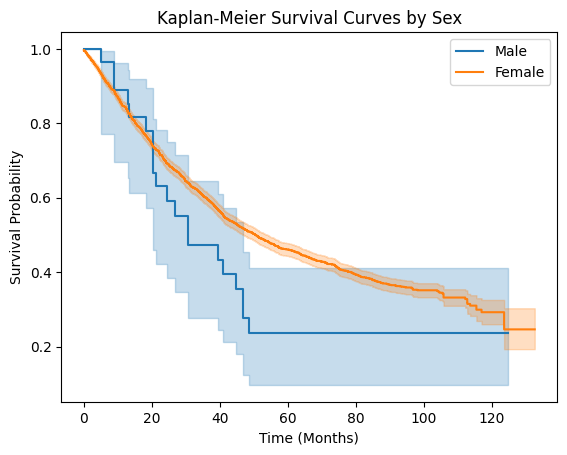

Jumlah Male: 30
Jumlah Female: 3626


In [17]:
from lifelines import KaplanMeierFitter
import matplotlib.pyplot as plt

# Buat Kaplan-Meier fitter
kmf = KaplanMeierFitter()

# Pisahkan data berdasarkan jenis kelamin
male = df[df['Sex'] == 'Male']
female = df[df['Sex'] == 'Female']

# Fit model untuk Male
kmf.fit(male['Overall Survival (Months)'], male['Overall Survival Status'], label='Male')
ax = kmf.plot()

# Fit model untuk Female
kmf.fit(female['Overall Survival (Months)'], female['Overall Survival Status'], label='Female')
kmf.plot(ax=ax)

# Tambahkan label dan judul
plt.xlabel('Time (Months)')
plt.ylabel('Survival Probability')
plt.title('Kaplan-Meier Survival Curves by Sex')
plt.legend()
plt.show()

# Print jumlah sampel per kelompok
print(f"Jumlah Male: {len(male)}")
print(f"Jumlah Female: {len(female)}")

### Overall Survival Curve

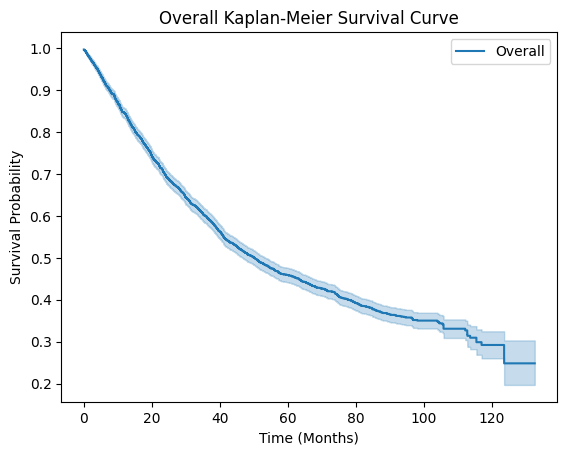

Median Survival Time (Overall): 50.13643686 months


In [18]:
# Overall Kaplan-Meier Survival Curve
kmf_overall = KaplanMeierFitter()
kmf_overall.fit(df['Overall Survival (Months)'], df['Overall Survival Status'], label='Overall')
kmf_overall.plot()
plt.xlabel('Time (Months)')
plt.ylabel('Survival Probability')
plt.title('Overall Kaplan-Meier Survival Curve')
plt.show()

# Median survival time overall
median_overall = kmf_overall.median_survival_time_
print(f"Median Survival Time (Overall): {median_overall} months")

### Median Survival Times

In [19]:
# Median survival times per group
kmf_male = KaplanMeierFitter()
kmf_male.fit(male['Overall Survival (Months)'], male['Overall Survival Status'])

kmf_female = KaplanMeierFitter()
kmf_female.fit(female['Overall Survival (Months)'], female['Overall Survival Status'])

median_male = kmf_male.median_survival_time_
median_female = kmf_female.median_survival_time_

print(f"Median Survival Time (Male): {median_male} months")
print(f"Median Survival Time (Female): {median_female} months")
print(f"Median Survival Time (Overall): {median_overall} months")

Median Survival Time (Male): 30.70651281 months
Median Survival Time (Female): 50.39944768 months
Median Survival Time (Overall): 50.13643686 months


## Conclusion

Analisis survival breast cancer MSK 2025 telah selesai, termasuk preprocessing data, pemodelan Cox Proportional Hazards, dan perbandingan kurva Kaplan-Meier berdasarkan jenis kelamin. Periksa hasil uji asumsi dan interpretasi model untuk wawasan lebih lanjut.